In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Modélisation
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import callbacks

#Evaluate
import random
from math import ceil
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Données manquantes : interpolation

In [2]:
df_inter = pd.read_csv('../data/interpolation_linear.csv', delimiter=",")

In [3]:
df_inter.DateTime = pd.to_datetime(df_inter.DateTime,format="%Y-%m-%d %H:%M:%S")

In [4]:
df_inter  = df_inter.set_index('DateTime')

# Consommation totale par HEURE

In [5]:
df_heure = df_inter.copy()
df_final = df_heure.resample('H').sum()

# Division dataset train - test

In [6]:
df_final.Global_active_power.describe()

count    34589.000000
mean        65.414219
std         53.652934
min          2.804000
25%         20.572000
50%         48.192940
75%         94.722000
max        393.632000
Name: Global_active_power, dtype: float64

In [7]:
y = df_final.Global_active_power

In [8]:
y_train, y_test = train_test_split(y, test_size=0.3, shuffle=False)

# Scaling : MinMaxScaler()

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

In [9]:
# prepare data for normalization
values = y_train.values # values est un array
values = values.reshape((len(values), 1)) # OU values.reshape(-1, 1)), deviens de dimension 2D une espèce de liste disposée en colonne
values_test = y_test.values
values_test = values_test.reshape((len(values_test), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
normalized_train = scaler.transform(values)
normalized_test = scaler.transform(values_test)

In [10]:
# y_train1 = y_train.copy()
# y_test1 = y_test.copy()

In [11]:
# y_train1 = y_train1.reset_index()
# y_test1 = y_test1.reset_index()
# y_train1.DateTime

In [12]:
# train1_generator = TimeseriesGenerator(normalized_train, normalized_train, length=length, batch_size=batch_size, shuffle=shuffle)

# Data Generator

In [13]:
# normalized_train.shape[0]

In [14]:
# normalized_train.shape[0]-24

In [15]:
#Parametrages
# batch_size = 16384
batch_size = 516
length = 24
shuffle = True

In [21]:
train_generator = TimeseriesGenerator(normalized_train, normalized_train, length=length, batch_size=batch_size, shuffle=shuffle)
test_generator = TimeseriesGenerator(normalized_test, normalized_test, length=length, batch_size=batch_size, shuffle=shuffle)
# OU au lieu de faire un train-test split, 
# on utilise start_index et end_index pour définir le début et la fin des train et test generators

In [22]:
# normalized_train

In [23]:
# normalized_train.shape

In [24]:
# plt.subplots(figsize=(16,5))

# plt.plot(pd.Series(train_generator[0][0][0].reshape(24,)))

# b = pd.Series(train_generator[0][0][1].reshape(24,))
# b.index = b.index+1
# plt.plot(b)

# c= pd.Series(train_generator[0][0][2].reshape(24,))
# c.index = c.index+2
# plt.plot(c)

# plt.show()

In [25]:
# plt.subplots(figsize=(16,5))

# plt.plot(normalized_train)
# nt = pd.Series(normalized_test.reshape(10377,))
# nt.index=nt.index+len(normalized_train)
# plt.plot(nt)


# for i in range(0, batch_size):
#     tg= pd.Series(train_generator[0][0][i].reshape(24,))
#     tg.index = tg.index+i
#     plt.plot(tg)

# plt.show()

In [26]:
train_generator[0]  # = train_generator.__getitem__(0)

(array([[[0.0478622 ],
         [0.05460496],
         [0.0475463 ],
         ...,
         [0.0215903 ],
         [0.05487944],
         [0.26466628]],
 
        [[0.02770125],
         [0.01994863],
         [0.02635477],
         ...,
         [0.09529975],
         [0.08036417],
         [0.09652712]],
 
        [[0.19461822],
         [0.17242719],
         [0.03550566],
         ...,
         [0.27624083],
         [0.28670713],
         [0.20916021]],
 
        ...,
 
        [[0.0145627 ],
         [0.02279695],
         [0.01852446],
         ...,
         [0.22051726],
         [0.01519451],
         [0.0231025 ]],
 
        [[0.20122633],
         [0.25547914],
         [0.46307018],
         ...,
         [0.2771264 ],
         [0.25904213],
         [0.1905011 ]],
 
        [[0.22601193],
         [0.19203919],
         [0.20779301],
         ...,
         [0.25411712],
         [0.08433629],
         [0.05254381]]]),
 array([[2.67193520e-01],
        [8.85621660e-02],
   

In [27]:
x, y = train_generator[0]
print(x.shape)
print(y.shape)

(516, 24, 1)
(516, 1)


# Modelisation

In [28]:
model = Sequential()
model.add(InputLayer(input_shape=(train_generator.length,1)))
model.add(SimpleRNN(30, activation="tanh"))
model.add(Dense(1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [31]:
early_stopping = callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

In [32]:
early_stop = callbacks.EarlyStopping(monitor="loss",mode="min",verbose=1,patience=100)

In [33]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator,callbacks=[early_stopping])

Epoch 1/50
47/47 [==============================] - 3s 23ms/step - loss: 0.0268 - mae: 0.1153 - val_loss: 0.0110 - val_mae: 0.0795
Epoch 2/50
47/47 [==============================] - 1s 17ms/step - loss: 0.0123 - mae: 0.0806 - val_loss: 0.0084 - val_mae: 0.0663
Epoch 3/50
47/47 [==============================] - 1s 16ms/step - loss: 0.0101 - mae: 0.0716 - val_loss: 0.0074 - val_mae: 0.0626
Epoch 4/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0091 - mae: 0.0669 - val_loss: 0.0071 - val_mae: 0.0606
Epoch 5/50
47/47 [==============================] - 1s 16ms/step - loss: 0.0090 - mae: 0.0661 - val_loss: 0.0077 - val_mae: 0.0599
Epoch 6/50
47/47 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0655 - val_loss: 0.0073 - val_mae: 0.0592
Epoch 7/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0090 - mae: 0.0658 - val_loss: 0.0075 - val_mae: 0.0595
Epoch 8/50
47/47 [==============================] - 1s 15ms/step - loss: 0.0092 - m

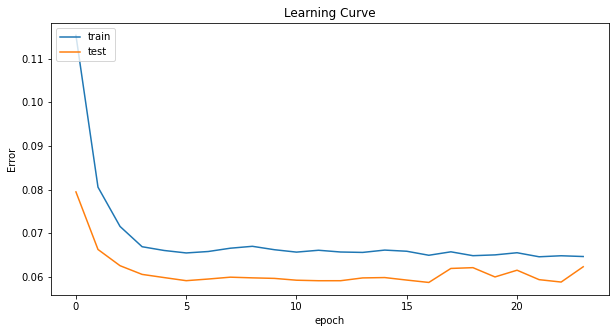

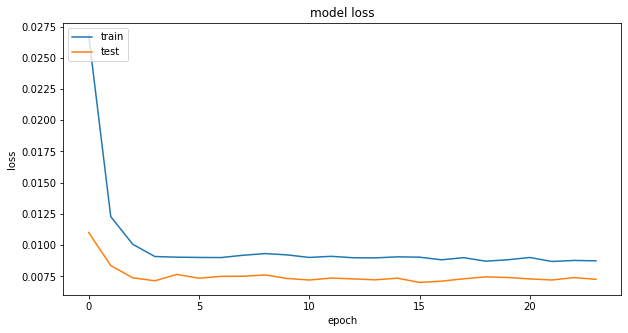

In [34]:
plt.figure(figsize=(10,5))

# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Learning Curve')
plt.ylabel('Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
# # Enregistrer le modèle
# model.save('models/model_batch516')
# # Récupérer le modèle :
# reconstructed_model = tf.keras.models.load_model("models/model_batch516")

INFO:tensorflow:Assets written to: models/model_batch516\assets


# Predictions

In [36]:
def plot_multivariate_serie(sequence, labels=None, predictions=None, only_features=None,
                            columns=3, width=5,height=4,wspace=0.3,hspace=0.2,ms=6,lw=1,
                            time_dt=1, hide_ticks=False):
    
    sequence_len = len(sequence)
    features_len = sequence.shape[1]
    if only_features is None : only_features=range(features_len)
    if labels is None        : labels=range(features_len)
    
    t  = np.arange(sequence_len)    
    if predictions is None:
        dt = 0
    else:
        dt = len(predictions)
        sequence_with_pred = sequence.copy()
        sequence_with_pred[-dt:]=predictions

    rows = ceil(features_len/columns)
    fig  = plt.figure(figsize=(columns*width, rows*height))
    fig.subplots_adjust(wspace=0.3,hspace=0.2)
    n=1
    for i in only_features:
        ax=fig.add_subplot(rows, columns, n)
        
        # ---- Real sequence without prediction
        #
        ax.plot( t[:-dt],sequence[:-dt,i], 'o',  markersize=ms, color='C0', zorder=2)
        ax.plot( t,sequence[:,i],          '-',  linewidth=lw,  color='C0', label=labels[i],zorder=1)

        # ---- What we expect
        #
        ax.plot(t[-dt:], sequence[-dt:,i], 'o', markeredgecolor='C0',markerfacecolor='white',ms=6)
        
        if predictions is not None:
            ax.plot(t[-dt-1:], sequence_with_pred[-dt-1:,i], '--',  lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=1)
            ax.plot(t[-dt:],   predictions[:,i],             'o',   lw=lw, fillstyle='full',  ms=ms, color='C1',zorder=2)

        if hide_ticks:
            ax.set_yticks([])
            ax.set_xticks([])
        
        ax.legend(loc="upper left")
        n+=1
    plt.show()

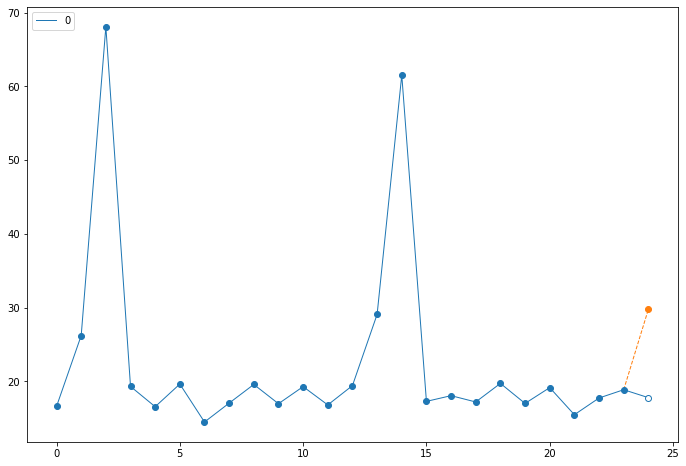

Différence prédiction-réalité : 11.977028869628896 KWH


In [37]:
s=random.randint(0,len(normalized_test)-train_generator.length) #sélection d'une séquence aléatoire
sequence = normalized_test[s:s+train_generator.length]
sequence_true = normalized_test[s:s+train_generator.length+1]

sequence = np.asarray(sequence).reshape(-1, 1)

pred = model.predict(np.array([sequence]))

#Denormalisation des données
inversed_sequence_true = scaler.inverse_transform(sequence_true)
inversed_pred = scaler.inverse_transform(pred)

# Représentation graphique de la prédiction
plot_multivariate_serie(inversed_sequence_true, predictions=inversed_pred,width=14, height=8)

# Différence prédiction-réalité
delta=abs(inversed_sequence_true[-1]-inversed_pred[-1])
print(f'Différence prédiction-réalité : {delta[0]} KWH')

In [ ]:
# s

In [ ]:
# sequence

In [ ]:
# sequence_true

In [ ]:
# # s=random.randint(0,len(normalized_test)-train_generator.length) #sélection d'une séquence aléatoire
# s_finale=len(normalized_test)-train_generator.length
# sequence_finale = normalized_test[s_finale:s+train_generator.length]
# sequence_true_finale = normalized_test[s_finale:s+train_generator.length+1]

# sequence_finale = np.asarray(sequence_finale).reshape(-1, 1)

# pred_finale = model.predict(np.array([sequence_finale]))

# #Denormalisation des données
# inversed_sequence_true_finale = scaler.inverse_transform(sequence_true_finale)
# inversed_pred_finale = scaler.inverse_transform(pred_finale)

# # Représentation graphique de la prédiction
# plot_multivariate_serie(inversed_sequence_true_finale, predictions=inversed_pred_finale,width=14, height=8)

# # Différence prédiction-réalité
# delta=abs(inversed_sequence_true[-1]-inversed_pred[-1])
# print(f'Différence prédiction-réalité : {delta[0]} KWH')

# Predictions sur plusieurs pas de temps (forecast)

In [38]:
def get_prediction(dataset, model, iterations,sequence_len):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = scaler.inverse_transform(sequence_true)
    pred          = scaler.inverse_transform(pred)

    return sequence_true,pred

In [39]:
# dataset = normalized_test
# model = model
# iterations = 12
# sequence_len = train_generator.length

# # ---- Initial sequence

# s=random.randint(0,len(dataset)-sequence_len-iterations) # 8337

# sequence_pred = dataset[s:s+sequence_len].copy() #array([[0.12311493],[0.07346605],...,[0.26107739]])
# sequence_true = dataset[s:s+sequence_len+iterations].copy() #array([[ 54.986],[ 35.812],...,[ 46.74 ]])

#     # ---- Iterate

# sequence_pred=list(sequence_pred) #[array([0.12311493]),array([0.07346605]),...,array([0.26107739])]

# for i in range(iterations):
#     sequence=sequence_pred[-sequence_len:] #[array([0.12311493]),array([0.07346605]),...,array([0.26107739])]
#     pred = model.predict( np.array([sequence]) ) #array([[0.20894438]], dtype=float32)
#     sequence_pred.append(pred[0]) #pred[0] = array([0.20894438], dtype=float32)

#     # ---- Extract the predictions    

# pred=np.array(sequence_pred[-iterations:]) #array([[0.20894438],[0.31906977],...,[0.1022564 ]], dtype=float32)

#     # ---- De-normalization

# sequence_true = scaler.inverse_transform(sequence_true)
# # pred = scaler.inverse_transform(pred)

In [40]:
def get_prediction_finale(dataset, model, iterations,sequence_len):

    # ---- Initial sequence

    s=len(normalized_test)

    sequence_pred = dataset[s-24:s].copy()
    sequence_true = dataset[s-24:s+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = scaler.inverse_transform(sequence_true)
    pred          = scaler.inverse_transform(pred)

    return sequence_true,pred

In [41]:
# dataset = normalized_test
# model = model
# iterations = 12
# sequence_len = train_generator.length

# # ---- Initial sequence

# s=len(normalized_test)

# sequence_pred = dataset[s-24:s].copy()
# sequence_true = dataset[s-24:s+iterations].copy()

#     # ---- Iterate

# sequence_pred=list(sequence_pred)

# for i in range(iterations):
#     sequence=sequence_pred[-sequence_len:]
#     pred = model.predict( np.array([sequence]) )
#     sequence_pred.append(pred[0])

#     # ---- Extract the predictions    

# pred=np.array(sequence_pred[-iterations:])

#     # ---- De-normalization

# sequence_true = scaler.inverse_transform(sequence_true)
# pred = scaler.inverse_transform(pred)

In [42]:
# sequence_pred.shape

In [43]:
# sequence_true.shape

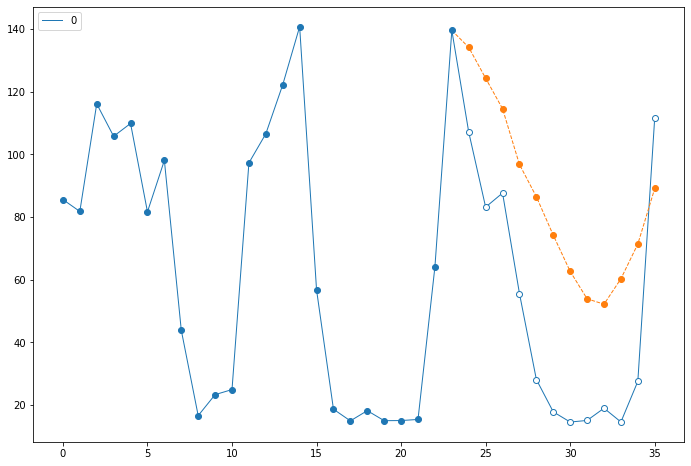

In [44]:
sequence_true_it, pred_it = get_prediction(normalized_test,model=model,iterations=12,sequence_len=train_generator.length)

plot_multivariate_serie(sequence_true_it, predictions=pred_it,width=14, height=8)

In [ ]:
# sequence_true_it_finale, pred_it_finale = get_prediction_finale(normalized_test,model=model,iterations=12,sequence_len=train_generator.length)

# plot_multivariate_serie(sequence_true_it_finale, predictions=pred_it_finale,width=14, height=8)

In [49]:
val_mae = 0.0623
val_mae = np.asarray(val_mae).reshape(1, -1)
scaler.inverse_transform(val_mae)

array([[31.4997616]])